## **Importando pacotes**

In [1]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import sys


from sklearn.metrics 	     import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose 	     import ColumnTransformer
from sklearn.pipeline 	     import Pipeline
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing   import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.impute          import KNNImputer

from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.neighbors       import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest
from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder



sys.path.append('../utils')

from modelcrafterclass import ModelCrafter
from funcs import curve
import warnings
warnings.filterwarnings("ignore")

## **Carregando os dados**

In [2]:
data = pd.read_csv('../datasets_for_ml/dataset_for_train.csv')

In [3]:
data.head()

,Client,data_recente,target,qt_faltas,moda_staff_faltante,moda_servico_faltante,moda_servico_cancelado,moda_staff_cancelado,antecedencia,qt_cancelamentos,...,media,mediana,desvio_padrao,min,max,sum,qte_servico_recebido,recencia,ultimo_pagamento,ultimo_staff
0,KERT01,2018-06-20,0,0,nenhum,nenhum,nenhum,nenhum,NaN,0,...,84.666667,82.0,16.165808,70.0,102.0,254.0,3,50.0,172.0,JJ
1,COOM01,2018-06-15,0,0,nenhum,nenhum,nenhum,nenhum,NaN,0,...,70.000000,70.0,NaN,70.0,70.0,70.0,1,71.0,70.0,SINEAD
2,PEDM01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,NaN,0,...,60.000000,60.0,NaN,60.0,60.0,60.0,1,7.0,60.0,BECKY
3,BAIS01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,NaN,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,0.0,nenhum
4,FRAL01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,NaN,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,0.0,nenhum


Apesar de haver valores faltantes, esses não são advindos de erros ou problemas. Na realidade, esses valores nulos tem seus significados dentro do contexto do nosso problema.

Por exemplo, um registro com a media faltante está associado a um novo cliente. Antecedência faltante indica que um cliente nunca fez um cancelamento e assim por diante.

Portanto, devemos achar uma maneira de introduzir essas informações na nossa base de dados

In [4]:
data.isna().sum().to_frame('qte. missing').sort_values(by='qte. missing',ascending=False)

,qte. missing
antecedencia,734
desvio_padrao,590
qte_servicos_por_dia,461
recencia,461
max,461
min,461
mediana,461
media,461
Client,0
ultimo_pagamento,0


Como todos os valores nulos são numéricos, vamos substitui-los por -1

In [5]:
data = data.fillna(-1)

Vamos adicionar uma nova coluna, indicando se temos um novo cliente. Onde novo cliente é todo cliente sem nenhum histórico. O registro receberá 1 se for um cliente sem histórico e 0 se for um cliente com histórico.

In [6]:
data['novo_cliente'] = data.apply(lambda x: 1 if x['qte_servico_recebido'] == 0  and x['qt_cancelamentos'] == 0 and x['qt_faltas'] == 0 else 0,axis=1)

# **Breve EDA**

Ao todo há 798 registros, ou seja, 798 clientes únicos

In [7]:
data.shape

(798, 24)

Estamos lidando com um problema de classes desbalanceadas onde 751 (94%) clientes seguiram as políticas do salão enquanto 47 (5.9%) não seguiram

In [8]:
pd.concat([data['target'].value_counts().to_frame('Absoluto'),round(data['target'].value_counts(normalize=True).mul(100).to_frame('%'),2)],axis=1)

,Absoluto,%
target,,
0,751,94.11
1,47,5.89


Observamos que 442 (55%) são novos clientes e 356 (45%) são clientes com algum histórico.

In [9]:
pd.concat([data['novo_cliente'].value_counts().to_frame('Absoluto'),round(data['novo_cliente'].value_counts(normalize=True).mul(100).to_frame('%'),2)],axis=1)

,Absoluto,%
novo_cliente,,
1,442,55.39
0,356,44.61


Da observação acima, podemos notar um problema. Mais da metade do dataset são de novos clientes e, portanto, não tem nenhum histórico associado.

Clientes sem histórico podem ser um problema, pois a única informação que adquirimos sobre eles está no momento da reserva, o que pode não ser muito informativo.

Tomando somente os clientes que tem algum histórico também observamos um desbalanceamento dos dados, onde ~93% deles seguem a política do salão e 7% não seguem

In [10]:
data.query('novo_cliente == 0')['target'].value_counts(normalize=True).mul(100)

target
0    92.134831
1     7.865169
Name: proportion, dtype: float64

O mesmo ocorre para os clientes sem histórico

In [11]:
data.query('novo_cliente == 1')['target'].value_counts(normalize=True).mul(100)

target
0    95.701357
1     4.298643
Name: proportion, dtype: float64

Além disso, notamos que todas as colunas são exatamente iguais para todos os clientes sem histórico. Aquilo que não varia, enviesa. Portanto, acredito ser uma boa considerarmos apenas clientes com algum histórico.

In [12]:
data.query('novo_cliente == 1')

,Client,data_recente,target,qt_faltas,moda_staff_faltante,moda_servico_faltante,moda_servico_cancelado,moda_staff_cancelado,antecedencia,qt_cancelamentos,...,mediana,desvio_padrao,min,max,sum,qte_servico_recebido,recencia,ultimo_pagamento,ultimo_staff,novo_cliente
3,BAIS01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
4,FRAL01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
7,CHOT01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
8,KUZD01,2018-06-09,0,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
9,TINT01,2018-04-05,0,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,MARR02,2018-06-09,1,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
793,CARS01,2018-05-25,1,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
794,SHMS01,2018-07-13,1,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1
795,COLS01,2018-04-22,1,0,nenhum,nenhum,nenhum,nenhum,-1.0,0,...,-1.0,-1.0,-1.0,-1.0,0.0,0,-1.0,0.0,nenhum,1


In [13]:
# selecionando somente clientes com histórico
data_to_train = data.query('novo_cliente == 0')

# **Definições**

Devemos estabelecer as métricas que vamos utilizar para a avaliação dos modelos. Vamos utilizar as três métricas citadas a seguir:

1. **Precision Score;**
2. **Recall Score;**
3. **F1 Score;**

A questão central do problema consiste em identificar faltas ou cancelamentos que fuja das políticas do salão. Tais ações acarretam em custos para o salão, desse modo, devemos selecionar se um cliente vai ou não seguir as políticas.

As ações para os possíveis clientes que vão descumprir as políticas não são conhecidas, entretanto, algo deve ser feito para mitigar os custos envolvidos. Uma maneira de fazer isso seria deixar determinados clientes avisados que existe a possibilidade de adiantar o atendimento deles, liberando, dessa maneira, horários nas futuras datas. Desse modo, o funcionário não vai deixar de trabalhar e vai existir a possibilidade de marcar clientes nos horários que ficaram vagos.

Os custos envolvidos nessas ações são desconhecidos, entretanto, podemos desconsidera-lo por enquanto. Podemos imaginar uma situação onde o contato com esses clientes é feito via ligação ou whatsapp. Desse modo podemos, em um primeiro momento, considerar esse custo como sendo zero.


Essas métricas serão convertidas para o problema de negócio através da matriz de confusão.

Verdadeiro Positivo - Existe a possibilidade de mitigar o custo do cliente não comparecer

Verdadeiro Negativo - Nenhum custo envolvido, teremos lucro devido ao comparecimento do cliente.

Falso Positivo - O modelo estima que o cliente não vai cumprir a politica mas na verdade ele vai. Vamos desconsiderar os custos 

Falso Negativo - O modelo estima que o cliente vai cumprir a politica mas na verdade ele não vai. Neste caso vamos ter um custo

# **Modelagem**

Definindo as features e o target

In [14]:
X = data_to_train.drop(['Client','data_recente','target','novo_cliente'],axis=1)

y = data_to_train['target']

Definindo as variáveis numéricas e categóricas

In [15]:
categoricas = X.select_dtypes(include ='object').columns

numericas = X.select_dtypes(exclude ='object').columns

Instanciando o modelcrafter

In [16]:
modelcrafter = ModelCrafter(folds = 10)

Adicionando os modelos de classificação na estrutura

In [17]:
modelos = [('regressao_logistica', LogisticRegression(class_weight='balanced', max_iter=100000)),
           ('svc',SVC(class_weight='balanced',C=1)),
           ('knn',KNeighborsClassifier(n_neighbors=20,p=1,weights='distance')),
           ('arvore',DecisionTreeClassifier(max_depth=5,class_weight='balanced', random_state = 0 )),
           ('floresta',RandomForestClassifier(n_estimators=500,min_samples_split=10,class_weight='balanced',random_state = 0)),
           ('adaboost',AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight='balanced', random_state = 0),random_state = 0)),
           ('gradientboost',GradientBoostingClassifier(max_depth=10,random_state = 0)),
           ('xgboost',XGBClassifier(max_depth=10,reg_alpha=0.5,random_state = 0))
          ] 

modelcrafter.AddModel(modelos = modelos)

Estabelecendo uma pipeline inicial para os modelos

In [18]:
numerical_transform = Pipeline([("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',TargetEncoder())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


model_pipeline = Pipeline([('preprocessor',preprocessor)])

model_pipeline.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  Index(['moda_staff_faltante', 'moda_servico_faltante',
       'moda_servico_cancelado', 'moda_staff_cancelado',
       'moda_staff_prestou_servico', 'moda_dia', 'ultimo_staff'],
      dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['qt_faltas', 'antecedencia', 'qt_cancelamentos', 'qte_servicos_por_dia',
       'media', 'mediana', 'desvio_padrao', 'min', 'max', 'sum',
       'qte_servico_recebido', 'recencia', 'ultimo_pagamento'],
      dtype='object'))]))])

Separando em treino e teste

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,stratify=y ,random_state = 42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Realizando uma baseline

In [20]:
baseline = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

baseline.sort_values(by='f1',ascending=False)

-----regressao_logistica-----
-----svc-----
-----knn-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboost-----
-----xgboost-----


,precision,recall,f1
gradientboost,0.256667,0.300000,0.269444
svc,0.192143,0.458333,0.248593
arvore,0.147024,0.500000,0.218911
regressao_logistica,0.130364,0.625000,0.205533
floresta,0.108333,0.275000,0.143571
adaboost,0.150000,0.150000,0.133333
xgboost,0.050000,0.100000,0.066667
knn,0.000000,0.000000,0.000000


Notamos que alguns modelos tem todas as métricas iguais a zero.

A seguir as expressões para precision e recall:

$Precision = \dfrac{VP}{VP+FP}$

$Recall = \dfrac{VP}{VP+FN}$

A única maneira de obtermos precision e recall iguais a zero é obtendo os verdadeiros positivos iguais a zero. Além disso, nos warnings observamos que há uma possível divisão por zero no precision. Isso ocorre somente se os verdadeiros positivos e os falsos positivos forem iguais a zero, portanto, podemos entender que esses modelos estão estimando somente 0's.

Poderíamos alterar os hiperparâmetros desses modelos afim de conseguir obter resultados mais consistentes. Entretanto, por agora, podemos seguir com os modelos que não deram nenhum problema. 

In [21]:
numerical_transform = Pipeline([#('polinomial',PolynomialFeatures(degree=3,interaction_only=False)),
                                ('power',PowerTransformer(standardize=False)),
                                ("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',CatBoostEncoder())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


model_pipeline = Pipeline([('preprocessor',preprocessor)])

model_pipeline.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  Index(['moda_staff_faltante', 'moda_servico_faltante',
       'moda_servico_cancelado', 'moda_staff_cancelado',
       'moda_staff_prestou_servico', 'moda_dia', 'ultimo_staff'],
      dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['qt_faltas', 'antecedencia', 'qt_cancelamentos', 'qte_servicos_por_dia',
       'media', 'mediana', 'desvio_padrao', 'min', 'max', 'sum',
       'qte_servico_recebido', 'recencia', 'ultimo_pagamento'],
      dtype='object'))]))])

In [22]:
baseline = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

baseline.sort_values(by='f1',ascending=False)

-----regressao_logistica-----
-----svc-----
-----knn-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboost-----
-----xgboost-----


,precision,recall,f1
gradientboost,0.203333,0.300000,0.200000
regressao_logistica,0.120309,0.625000,0.193443
svc,0.128651,0.508333,0.192366
arvore,0.115000,0.375000,0.168681
floresta,0.083333,0.125000,0.083333
adaboost,0.050000,0.100000,0.066667
xgboost,0.050000,0.100000,0.066667
knn,0.000000,0.000000,0.000000


In [23]:
        custo_mitigar = tp*55

        rendimento = tn*55

        gastos = fn*55

        print(tn,fp,fn,tp)

NameError: name 'tp' is not defined

In [28]:
y_test.value_counts()*55

target
0    5445
1     440
Name: count, dtype: int64

In [26]:
modelcrafter.Validacao(X_train,X_test,y_train,y_test,model_pipeline,0.3)


-----regressao_logistica-----
53 46 3 5
-----svc-----
-----knn-----
97 2 8 0
-----arvore-----
87 12 6 2
-----floresta-----
80 19 4 4
-----adaboost-----
98 1 7 1
-----gradientboost-----
95 4 6 2
-----xgboost-----
94 5 5 3


,modelo,f1_treino,f1_teste,rendimento,rendimento_n_contabilizado,custos_mitigar,gastos
0,regressao_logistica,0.296296,0.210526,2915.0,2530.0,275.0,165.0
1,svc,0.325203,0.200000,NaN,NaN,NaN,NaN
2,knn,0.482759,0.000000,5335.0,110.0,0.0,440.0
3,arvore,0.461538,0.181818,4785.0,660.0,110.0,330.0
4,floresta,0.358974,0.000000,4400.0,1045.0,220.0,220.0
5,adaboost,0.307692,0.000000,5390.0,55.0,55.0,385.0
6,gradientboost,0.516129,0.285714,5225.0,220.0,110.0,330.0
7,xgboost,0.342857,0.166667,5170.0,275.0,165.0,275.0


Os modelos que parecem ser mais promissores são o Gradient Boosting, Logistic Regression,Suporte Vector Machine e Decision Tree.

In [ ]:
lr = Pipeline([('preprocessor',preprocessor),('model', modelcrafter.models['regressao_logistica'] )])

gb = Pipeline([('preprocessor',preprocessor),('model', modelcrafter.models['gradientboost'] )])

svm = Pipeline([('preprocessor',preprocessor),('model', modelcrafter.models['svc'] )])

dt = Pipeline([('preprocessor',preprocessor),('model', modelcrafter.models['arvore'] )])

Regressão Logística
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       229
           1       0.18      0.80      0.30        20

    accuracy                           0.69       249
   macro avg       0.58      0.74      0.55       249
weighted avg       0.91      0.69      0.76       249

[[157  72]
 [  4  16]]


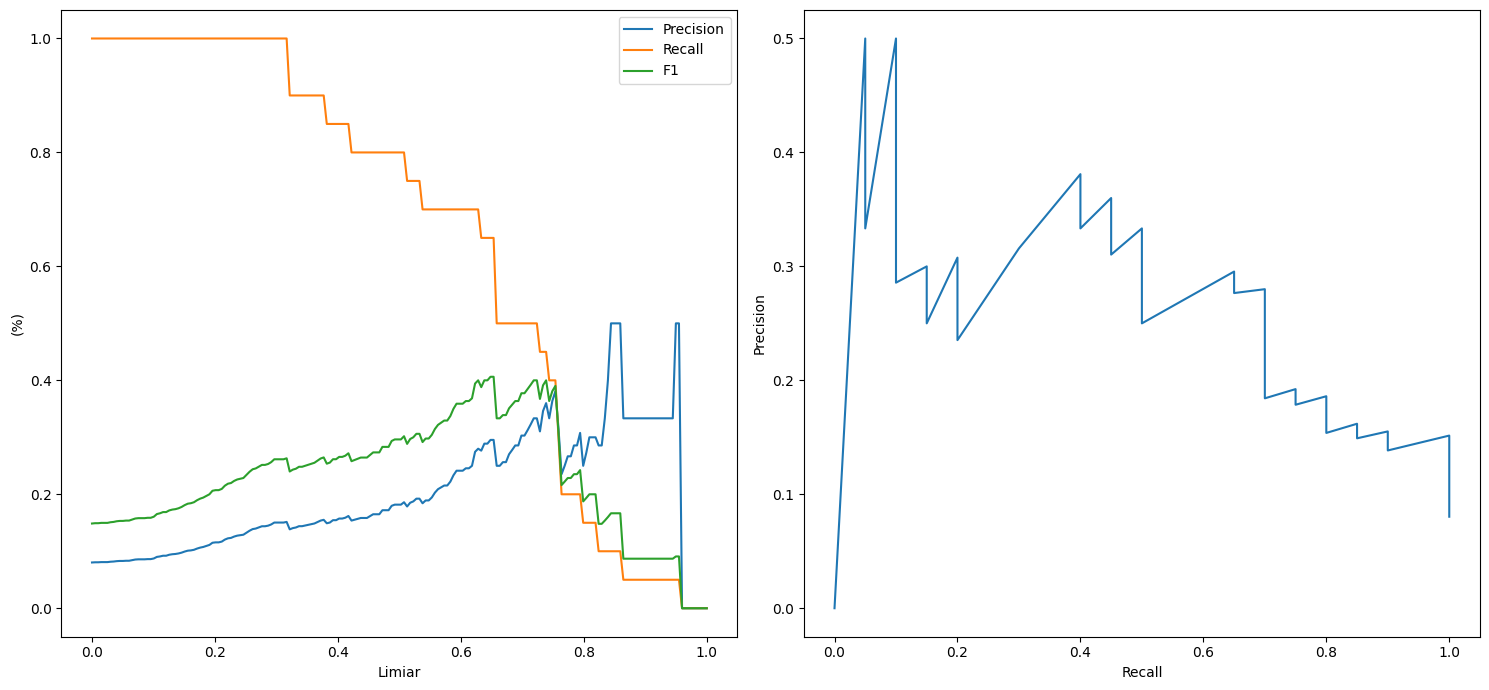

In [ ]:
print('Regressão Logística')

lr.fit(X_train,y_train)
pred = lr.predict(X_train)
print(classification_report(y_train,pred))
print(confusion_matrix(y_train,pred))
_ = curve(lr,X_train,y_train,qte=200)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       229
           1       0.73      0.40      0.52        20

    accuracy                           0.94       249
   macro avg       0.84      0.69      0.74       249
weighted avg       0.93      0.94      0.93       249

[[226   3]
 [ 12   8]]


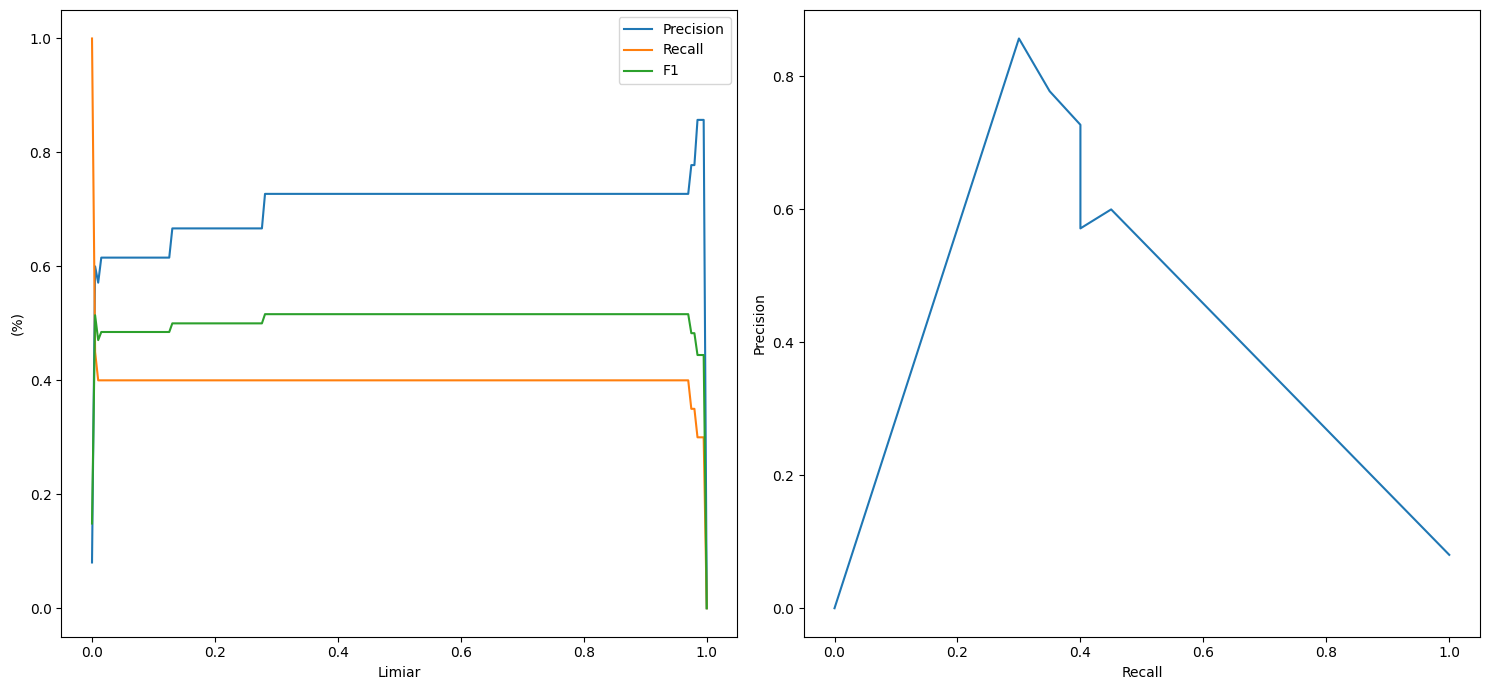

In [ ]:
print('Gradient Boosting')

gb.fit(X_train,y_train)
pred = gb.predict(X_train)
print(classification_report(y_train,pred))
print(confusion_matrix(y_train,pred))
_ = curve(gb,X_train,y_train,qte=200)

Decision tree
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       229
           1       0.38      0.60      0.46        20

    accuracy                           0.89       249
   macro avg       0.67      0.76      0.70       249
weighted avg       0.92      0.89      0.90       249

[[209  20]
 [  8  12]]


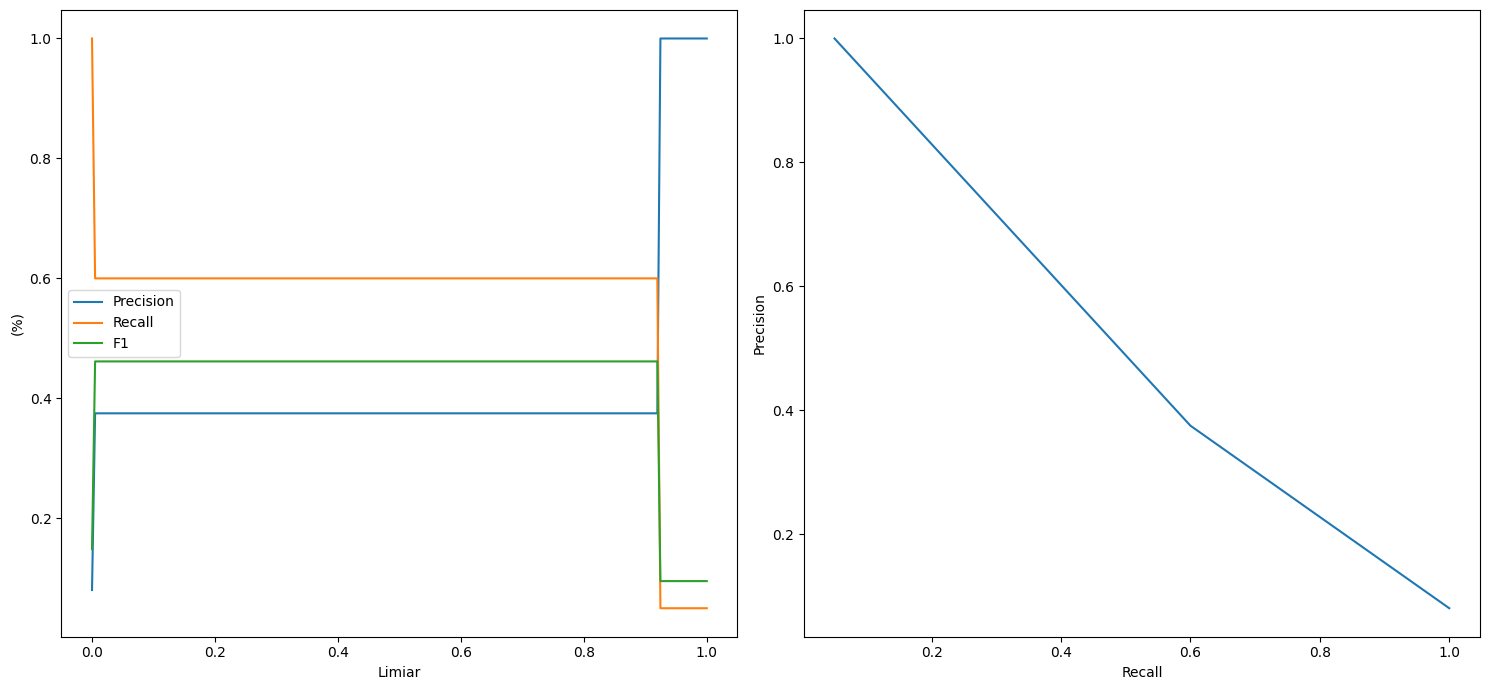

In [ ]:
print('Decision tree')

dt.fit(X_train,y_train)
pred = dt.predict(X_train)
print(classification_report(y_train,pred))
print(confusion_matrix(y_train,pred))
_ = curve(dt,X_train,y_train,qte=200)

Em termos de f1-score, os modelos baseados em árvores foram os que se destacaram no conjunto de treino. Esses modelos apresentam ~70% de f1 score e para os demais 55%.